# FinTrack

# Kode Pisah

In [ ]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# --- [0] Set seed untuk hasil yang konsisten ---
SEED = 35
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# --- [1] Load data ---
df = pd.read_csv("/content/data_keuangan_bulanan_extended_fluktuasi4.csv", sep=';')
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df['Jam'] = pd.to_datetime(df['Jam'], format='%H:%M').dt.time
df['Jumlah'] = df['Jumlah'].astype(float)

In [ ]:
df.info()

In [ ]:
# --- [2] Filter pengeluaran dan jumlah per hari ---
df_pengeluaran = df[df['Jenis'] == 'Pengeluaran']
df_harian = df_pengeluaran.groupby('Tanggal')['Jumlah'].sum().reset_index()

In [ ]:
df_harian

In [ ]:
# --- [3] Buat time series harian lengkap (isi nol jika tidak ada transaksi) ---
full_dates = pd.date_range(start=df_harian['Tanggal'].min(), end=df_harian['Tanggal'].max())
df_harian = df_harian.set_index('Tanggal').reindex(full_dates, fill_value=0).rename_axis('Tanggal').reset_index()

In [ ]:
df_harian

,Tanggal,Jumlah
0,2023-11-01,403000.0
1,2023-11-02,69000.0
2,2023-11-03,81000.0
3,2023-11-04,74000.0
4,2023-11-05,293000.0
...,...,...
330,2024-09-26,58000.0
331,2024-09-27,71000.0
332,2024-09-28,203000.0
333,2024-09-29,71000.0


In [ ]:
df_harian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  335 non-null    datetime64[ns]
 1   Jumlah   335 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.4 KB


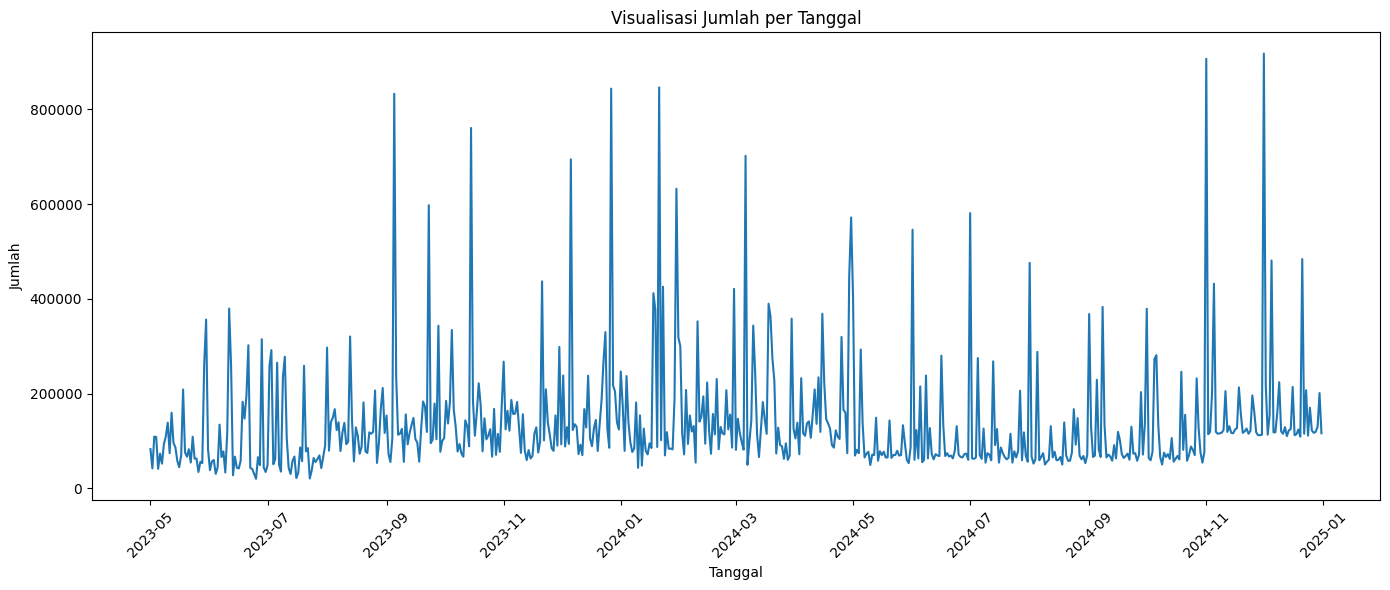

In [ ]:
# Atur ukuran plot
plt.figure(figsize=(14,6))

# Plot line chart dengan seaborn (lebih keren)
sns.lineplot(x='Tanggal', y='Jumlah', data=df_harian)

# Judul dan label
plt.title('Visualisasi Jumlah per Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')

# Rotasi label tanggal agar tidak saling tumpang tindih
plt.xticks(rotation=45)

# Tampilkan plot
plt.tight_layout()
plt.show()

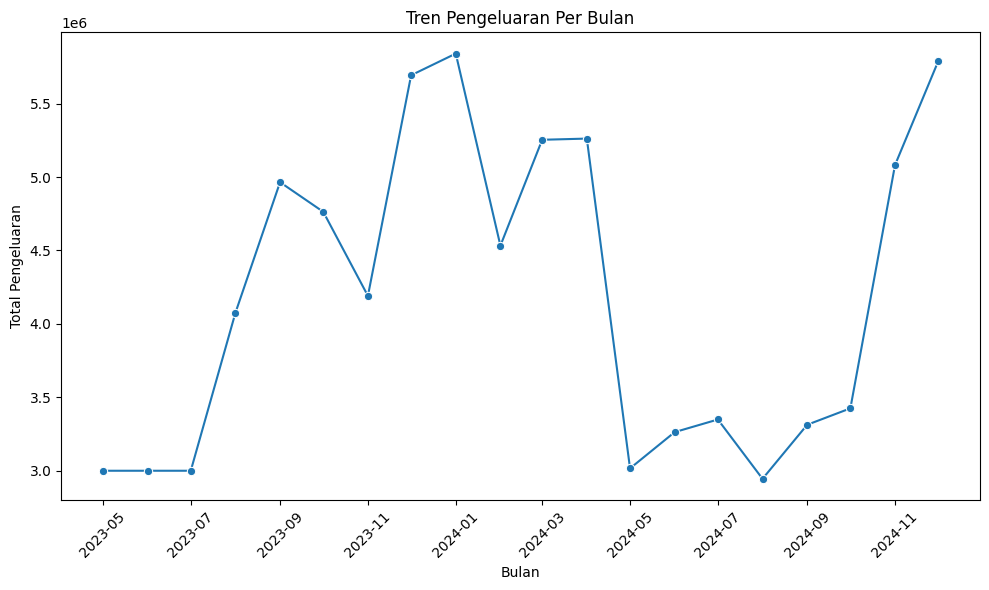

In [ ]:
# Buat kolom Tahun-Bulan
df_harian['TahunBulan'] = df_harian['Tanggal'].dt.to_period('M')

# Agregasi total jumlah per bulan
df_bulanan = df_harian.groupby('TahunBulan')['Jumlah'].sum().reset_index()

# Convert kembali ke datetime agar bisa di-plot dengan mudah
df_bulanan['TahunBulan'] = df_bulanan['TahunBulan'].dt.to_timestamp()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x='TahunBulan', y='Jumlah', data=df_bulanan, marker='o')

plt.title('Tren Pengeluaran Per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Pengeluaran')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# --- [4] Scaling ---
scaler = MinMaxScaler()
scaled_amounts = scaler.fit_transform(df_harian[['Jumlah']])

In [ ]:
# --- [5] Buat window data (30 hari input ➝ 1 output bulanan) ---
X, y = [], []
window_size = 30
step = 30  # prediksi tiap bulan

for i in range(0, len(scaled_amounts) - window_size - step + 1, step):
    X.append(scaled_amounts[i:i+window_size])
    y.append(np.sum(scaled_amounts[i+window_size:i+window_size+step]))  # jumlah bulan berikutnya

X, y = np.array(X), np.array(y)

In [ ]:
# --- [6] Bangun dan latih model LSTM ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# --- [7] Prediksi total bulanan dan evaluasi ---
y_pred = model.predict(X)
y_pred_inv = scaler.inverse_transform(y_pred)
y_actual_inv = scaler.inverse_transform(y.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


In [ ]:
# --- [8] Prediksi bulan depan (berdasarkan 30 hari terakhir) ---
last_30 = df_harian['Jumlah'].values[-30:].reshape(-1, 1)
last_30_scaled = scaler.transform(last_30).reshape(1, window_size, 1)
pred_scaled_next = model.predict(last_30_scaled)
pred_rp_next = scaler.inverse_transform(pred_scaled_next)[0][0]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


In [ ]:
# --- [9] Rekomendasi alokasi pengeluaran per kategori ---
# Hitung total historis per kategori
kategori_summary = df_pengeluaran.groupby('Kategori')['Jumlah'].sum()
kategori_persen = kategori_summary / kategori_summary.sum()

# Rekomendasi alokasi berdasarkan prediksi bulan depan
rekomendasi = (kategori_persen * pred_rp_next).sort_values(ascending=False)

In [ ]:
kategori_persen

,Jumlah
Kategori,
Belanja Bulanan,0.129746
Bensin,0.077861
Listrik Kos,0.059572
Makan Malam,0.215228
Makan Pagi,0.212941
Makan Siang,0.212213
Rekreasi,0.072659
Transportasi Umum,0.019780


In [ ]:
rekomendasi

,Jumlah
Kategori,
Makan Malam,758211.228149
Makan Pagi,750157.568244
Makan Siang,747589.734651
Belanja Bulanan,457074.379531
Bensin,274291.315602
Rekreasi,255966.321326
Listrik Kos,209862.036363
Transportasi Umum,69681.666134


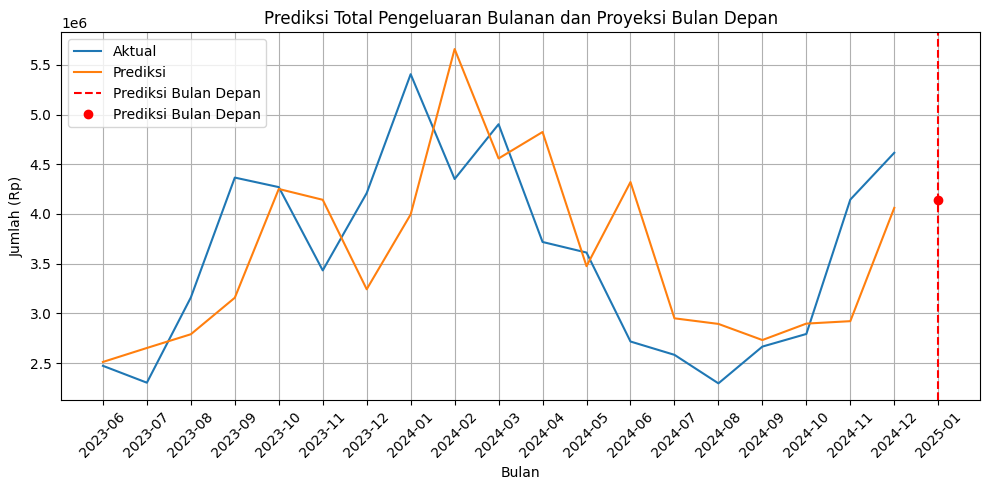

MAE  (Mean Absolute Error): Rp 657,267
MAPE (Mean Absolute % Error): 18.11%

✅ Prediksi total pengeluaran bulan depan: Rp 4,143,006

📊 Rekomendasi alokasi pengeluaran per kategori:
Kategori
Makan Pagi           860173
Makan Malam          840022
Makan Siang          839091
Belanja Bulanan      580150
Listrik Kos          322425
Rekreasi             314157
Bensin               298565
Transportasi Umum     88422
Name: Jumlah, dtype: int64


In [ ]:
# --- [10] Visualisasi ---
# Ambil tanggal terakhir dari setiap window prediksi aktual
tanggal_akhir_bulan = [df_harian['Tanggal'].iloc[i+window_size+step-1] for i in range(0, len(scaled_amounts) - window_size - step + 1, step)]
bulan_labels = pd.to_datetime(tanggal_akhir_bulan).to_series().dt.to_period('M').astype(str).tolist()
next_bulan = (pd.to_datetime(bulan_labels[-1]) + pd.DateOffset(months=1)).strftime('%Y-%m')


plt.figure(figsize=(10, 5))
plt.plot(bulan_labels, y_actual_inv.flatten(), label='Aktual')
plt.plot(bulan_labels, y_pred_inv.flatten(), label='Prediksi')
plt.axvline(x=next_bulan, color='red', linestyle='--', label='Prediksi Bulan Depan')
plt.plot(next_bulan, pred_rp_next, 'ro', label='Prediksi Bulan Depan')

plt.title('Prediksi Total Pengeluaran Bulanan dan Proyeksi Bulan Depan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah (Rp)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Evaluasi
mae = mean_absolute_error(y_actual_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_actual_inv, y_pred_inv) * 100  # persen

print(f"MAE  (Mean Absolute Error): Rp {mae:,.0f}")
print(f"MAPE (Mean Absolute % Error): {mape:.2f}%")

# --- [11] Tampilkan hasil ---
print(f"\n✅ Prediksi total pengeluaran bulan depan: Rp {pred_rp_next:,.0f}")
print("\n📊 Rekomendasi alokasi pengeluaran per kategori:")
print(rekomendasi.round(0).astype(int))

In [ ]:
# --- [12] Simpan model dan kategori persen ---

# Simpan model LSTM ke file .h5
model.save("model_prediksi_lstm.h5")

# Simpan scaler untuk normalisasi (penting jika ingin prediksi ulang)
import joblib
joblib.dump(scaler, "scaler.pkl")

# Simpan proporsi alokasi kategori ke JSON
import json
kategori_persen_dict = kategori_persen.to_dict()

with open("kategori_persen.json", "w") as f:
    json.dump(kategori_persen_dict, f, indent=4)

print("\n✅ Model, scaler, dan proporsi kategori berhasil disimpan.")



✅ Model, scaler, dan proporsi kategori berhasil disimpan.


---

# Ini Kode Lengkap untuk Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


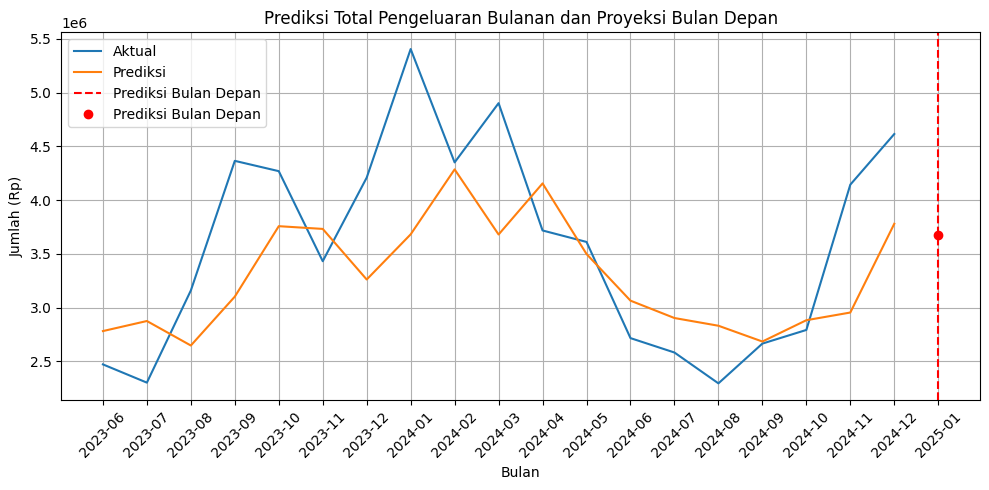

MAE  (Mean Absolute Error): Rp 595,866
MAPE (Mean Absolute % Error): 15.71%

✅ Prediksi total pengeluaran bulan depan: Rp 3,671,705

📊 Rekomendasi alokasi pengeluaran per kategori:
Kategori
Makan Pagi           762321
Makan Malam          744463
Makan Siang          743638
Belanja Bulanan      514153
Listrik Kos          285747
Rekreasi             278419
Bensin               264601
Transportasi Umum     78363
Name: Jumlah, dtype: int64

✅ Model, scaler, dan proporsi kategori berhasil disimpan.


In [ ]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- [0] Set seed untuk hasil yang konsisten ---
SEED = 35
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- [1] Load data ---
df = pd.read_csv("/content/data_keuangan_bulanan_extended_fluktuasi4.csv", sep=';')
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df['Jam'] = pd.to_datetime(df['Jam'], format='%H:%M').dt.time
df['Jumlah'] = df['Jumlah'].astype(float)

# --- [2] Filter pengeluaran dan jumlah per hari ---
df_pengeluaran = df[df['Jenis'] == 'Pengeluaran']
df_harian = df_pengeluaran.groupby('Tanggal')['Jumlah'].sum().reset_index()

# --- [3] Buat time series harian lengkap (isi nol jika tidak ada transaksi) ---
full_dates = pd.date_range(start=df_harian['Tanggal'].min(), end=df_harian['Tanggal'].max())
df_harian = df_harian.set_index('Tanggal').rein.dex(full_dates, fill_value=0).rename_axis('Tanggal').reset_index()

# --- [4] Scaling ---
scaler = MinMaxScaler()
scaled_amounts = scaler.fit_transform(df_harian[['Jumlah']])

# --- [5] Buat window data (30 hari input ➝ 1 output bulanan) ---
X, y = [], []
window_size = 30
step = 30  # prediksi tiap bulan

for i in range(0, len(scaled_amounts) - window_size - step + 1, step):
    X.append(scaled_amounts[i:i+window_size])
    y.append(np.sum(scaled_amounts[i+window_size:i+window_size+step]))  # jumlah bulan berikutnya

X, y = np.array(X), np.array(y)

# --- [6] Bangun dan latih model LSTM ---
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, 1))),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.2),
    Dense(1)
])

from tensorflow.keras.losses import Huber
model.compile(optimizer='adam', loss=Huber(delta=1.0))
model.fit(X, y, epochs=100, verbose=0)

# --- [7] Prediksi total bulanan dan evaluasi ---
y_pred = model.predict(X)
y_pred_inv = scaler.inverse_transform(y_pred)
y_actual_inv = scaler.inverse_transform(y.reshape(-1, 1))

# --- [8] Prediksi bulan depan (berdasarkan 30 hari terakhir) ---
last_30 = df_harian['Jumlah'].values[-30:].reshape(-1, 1)
last_30_scaled = scaler.transform(last_30).reshape(1, window_size, 1)
pred_scaled_next = model.predict(last_30_scaled)
pred_rp_next = scaler.inverse_transform(pred_scaled_next)[0][0]

# --- [9] Rekomendasi alokasi pengeluaran per kategori ---
# Hitung total historis per kategori
kategori_summary = df_pengeluaran.groupby('Kategori')['Jumlah'].sum()
kategori_persen = kategori_summary / kategori_summary.sum()

# Rekomendasi alokasi berdasarkan prediksi bulan depan
rekomendasi = (kategori_persen * pred_rp_next).sort_values(ascending=False)

# --- [10] Visualisasi ---
# Ambil tanggal terakhir dari setiap window prediksi aktual
tanggal_akhir_bulan = [df_harian['Tanggal'].iloc[i+window_size+step-1] for i in range(0, len(scaled_amounts) - window_size - step + 1, step)]
bulan_labels = pd.to_datetime(tanggal_akhir_bulan).to_series().dt.to_period('M').astype(str).tolist()
next_bulan = (pd.to_datetime(bulan_labels[-1]) + pd.DateOffset(months=1)).strftime('%Y-%m')


plt.figure(figsize=(10, 5))
plt.plot(bulan_labels, y_actual_inv.flatten(), label='Aktual')
plt.plot(bulan_labels, y_pred_inv.flatten(), label='Prediksi')
plt.axvline(x=next_bulan, color='red', linestyle='--', label='Prediksi Bulan Depan')
plt.plot(next_bulan, pred_rp_next, 'ro', label='Prediksi Bulan Depan')

plt.title('Prediksi Total Pengeluaran Bulanan dan Proyeksi Bulan Depan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah (Rp)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Evaluasi
mae = mean_absolute_error(y_actual_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_actual_inv, y_pred_inv) * 100  # persen

print(f"MAE  (Mean Absolute Error): Rp {mae:,.0f}")
print(f"MAPE (Mean Absolute % Error): {mape:.2f}%")

# --- [11] Tampilkan hasil ---
print(f"\n✅ Prediksi total pengeluaran bulan depan: Rp {pred_rp_next:,.0f}")
print("\n📊 Rekomendasi alokasi pengeluaran per kategori:")
print(rekomendasi.round(0).astype(int))

# --- [12] Simpan model dan kategori persen ---

# Simpan model LSTM ke file .h5
model.save("model_prediksi_lstm.h5")

# Simpan scaler untuk normalisasi (penting jika ingin prediksi ulang)
import joblib
joblib.dump(scaler, "scaler.pkl")

# Simpan proporsi alokasi kategori ke JSON
import json
kategori_persen_dict = kategori_persen.to_dict()

with open("kategori_persen.json", "w") as f:
    json.dump(kategori_persen_dict, f, indent=4)

print("\n✅ Model, scaler, dan proporsi kategori berhasil disimpan.")


In [ ]:
import numpy as np
import pandas as pd
import json
import joblib
from tensorflow.keras.models import load_model

# --- [1] Load model, scaler, dan proporsi kategori ---
model = load_model("model_prediksi_lstm.h5")
scaler = joblib.load("scaler.pkl")

with open("kategori_persen.json", "r") as f:
    kategori_persen = pd.Series(json.load(f))

# --- [2] Input data pengeluaran 30 hari terakhir ---
print("Masukkan total pengeluaran (Rp) selama 30 hari terakhir:")
pengeluaran_30hari = [  323672,       0,  237361,      0,
  829255,  112058,  229254, 220063,
  113854, 1040789,  623549, 311628,
  204715,  678850,  669128, 514308,
   86787, 1068091, 1105355, 850872,
  117371,  408304,   57892, 888614,
       0,  135587,  470873, 468748,
  823634, 142792]



'''for i in range(1, 6): , 500000, 410000, 130000, 12500,
    135000, 400000, 120000, 115000, 130000, 1250000
    while True:
        try:
            nominal = float(input(f"Hari ke-{i}: Rp "))
            pengeluaran_30hari.append(nominal)
            break
        except ValueError:
            print("Masukkan angka yang valid.")'''

# --- [3] Transformasi dan prediksi ---
# Ubah jadi array dan scaling
last_30 = np.array(pengeluaran_30hari).reshape(-1, 1)
last_30_scaled = scaler.transform(last_30).reshape(1, 30, 1)

# Prediksi bulan depan
pred_scaled_next = model.predict(last_30_scaled)
pred_rp_next = scaler.inverse_transform(pred_scaled_next)[0][0]

# --- [4] Hitung rekomendasi alokasi berdasark111an kategori historis ---
rekomendasi = (kategori_persen * pred_rp_next).sort_values(ascending=False)

# --- [5] Tampilkan hasil ---
print(f"\n✅ Prediksi total pengeluaran bulan depan: Rp {pred_rp_next:,.0f}")
print("\n📊 Rekomendasi alokasi pengeluaran per kategori:")
print(rekomendasi.round(0).astype(int))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Masukkan total pengeluaran (Rp) selama 30 hari terakhir:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step

✅ Prediksi total pengeluaran bulan depan: Rp 3,524,120

📊 Rekomendasi alokasi pengeluaran per kategori:
Makan Pagi           731680
Makan Malam          714539
Makan Siang          713747
Belanja Bulanan      493487
Listrik Kos          274261
Rekreasi             267228
Bensin               253965
Transportasi Umum     75214
dtype: int64


In [ ]:
sum(pengeluaran_30hari)

12733404

In [ ]:
import pandas as pd
import numpy as np
import calendar
from datetime import timedelta

# Load original transaction data
df = pd.read_csv('data_keuangan_bulanan.csv', sep=';',
                 parse_dates=['Tanggal'], dayfirst=True)

# Extract distributions
# 1. Category distribution
cat_probs = df['Kategori'].value_counts(normalize=True)

# 2. Keterangan distribution conditional on category
ket_probs = df.groupby('Kategori')['Keterangan'].value_counts(normalize=True).unstack(fill_value=0)

# 3. Amount statistics by category
amt_stats = df.groupby('Kategori')['Jumlah'].agg(['mean', 'std'])

# 4. Time distribution (in seconds since midnight)
times_in_secs = pd.to_datetime(df['Jam'], format='%H:%M').dt.hour * 3600 + pd.to_datetime(df['Jam'], format='%H:%M').dt.minute * 60
time_probs, time_bins = np.histogram(times_in_secs, bins=24, density=True)

# Determine the 12-month date range after the last date
last_date = df['Tanggal'].max()
start_date = last_date + timedelta(days=1)
end_date = last_date + pd.DateOffset(months=12)
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Compute daily transaction count distribution (historical)
daily_counts = df.groupby(df['Tanggal'].dt.to_period('D')).size().astype(int)
lambda_daily = daily_counts.mean()

# Generate new transactions
new_rows = []
for date in all_dates:
    # sample number of transactions
    n_trans = np.random.poisson(lambda_daily)
    for _ in range(n_trans):
        # sample time
        bin_idx = np.random.choice(len(time_probs), p=time_probs/time_probs.sum())
        # random second within bin
        sec = np.random.randint(time_bins[bin_idx], time_bins[bin_idx+1] if bin_idx+1<len(time_bins) else 86400)
        hh = sec // 3600
        mm = (sec % 3600) // 60
        jam = f"{hh:02d}:{mm:02d}"

        # sample category and keterangan
        kategori = np.random.choice(cat_probs.index, p=cat_probs.values)
        keterangan = np.random.choice(ket_probs.columns, p=ket_probs.loc[kategori].values)

        # sample amount with slight upward trend (1% per month)
        months_from_start = (date.year - start_date.year) * 12 + (date.month - start_date.month)
        trend_factor = 1 + 0.01 * months_from_start
        mean_amt, std_amt = amt_stats.loc[kategori]
        jumlah = max(0, np.random.normal(mean_amt * trend_factor, std_amt))

        # create row
        new_rows.append({
            'Tanggal': date.strftime('%d/%m/%Y'),
            'Jam': jam,
            'Jenis': 'Pengeluaran',
            'Kategori': kategori,
            'Jumlah': round(jumlah, 0),
            'Keterangan': keterangan
        })

# Create DataFrame and append
df_new = pd.DataFrame(new_rows)
df_augmented = pd.concat([df, df_new], ignore_index=True)

# Save to CSV
output_path = 'data_keuangan_bulanan_augmented.csv'
df_augmented.to_csv(output_path, sep=';', index=False)

# Display a sample of the new data
df_new.head(12)


In [ ]:
import pandas as pd

# Load original data
df = pd.read_csv("data_keuangan_bulanan.csv", sep=';')
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')

# Determine the earliest date
min_date = df['Tanggal'].min()

# Generate synthetic data by shifting the first 6 months forward rows back by 6 months
six_months_later = min_date + pd.DateOffset(months=6)
df_to_copy = df[df['Tanggal'] < six_months_later].copy()

# Shift dates back by 6 months
df_to_copy['Tanggal'] = df_to_copy['Tanggal'] - pd.DateOffset(months=6)

# Concatenate and sort
df_extended = pd.concat([df_to_copy, df], ignore_index=True)
df_extended = df_extended.sort_values(by='Tanggal').reset_index(drop=True)

# Save extended dataset
output_path = "data_keuangan_bulanan_extended.csv"
df_extended.to_csv(output_path, sep=';', index=False, date_format='%d/%m/%Y')


print(f"Extended dataset saved to: {output_path}")
print(f"Original rows: {len(df)}, New rows added: {len(df_to_copy)}, Total: {len(df_extended)}")


Extended dataset saved to: data_keuangan_bulanan_extended.csv
Original rows: 830, New rows added: 626, Total: 1456
